## Importing Required Libraries

In [42]:
!pip install git+https://github.com/openai/whisper.git

  Cloning https://github.com/openai/whisper.git to /tmp/pip-req-build-5jl9h2p9
  Running command git clone --filter=blob:none --quiet https://github.com/openai/whisper.git /tmp/pip-req-build-5jl9h2p9
  Resolved https://github.com/openai/whisper.git to commit 517a43ecd132a2089d85f4ebc044728a71d49f6e
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [43]:
import os
import librosa
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import whisper
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.ensemble import IsolationForest
import seaborn as sns
import warnings
import re

## Loading Data

In [44]:
AUDIO_DIR = "/content/voice_data"  # here paste the path of data folder
SAMPLE_RATE = 16000 #16000 samples per second

## Model for convert audio to text

In [45]:
# Whisper Model
model = whisper.load_model("tiny")

In [46]:
def transcribe_audio(file_path):
    result = model.transcribe(file_path)
    return result['text']

In [47]:
for file in os.listdir(AUDIO_DIR):
    if file.endswith(".mp3"):
      path = os.path.join(AUDIO_DIR, file)
      text = transcribe_audio(path)
      print(text)

/usr/local/lib/python3.11/dist-packages/whisper/transcribe.py:132: UserWarning: FP16 is not supported on CPU; using FP32 instead
  warnings.warn("FP16 is not supported on CPU; using FP32 instead")


 In this position he learned mathematics, Greek, Italian, Spanish, and several oriental languages.


/usr/local/lib/python3.11/dist-packages/whisper/transcribe.py:132: UserWarning: FP16 is not supported on CPU; using FP32 instead
  warnings.warn("FP16 is not supported on CPU; using FP32 instead")


 She herself defended her verse as Holy Eurotica.


/usr/local/lib/python3.11/dist-packages/whisper/transcribe.py:132: UserWarning: FP16 is not supported on CPU; using FP32 instead
  warnings.warn("FP16 is not supported on CPU; using FP32 instead")


 They followed the street car lines to areas south of the raccoon river.


/usr/local/lib/python3.11/dist-packages/whisper/transcribe.py:132: UserWarning: FP16 is not supported on CPU; using FP32 instead
  warnings.warn("FP16 is not supported on CPU; using FP32 instead")


 The key allows customers to buy plus bus for the Crawley and Brighton areas.


/usr/local/lib/python3.11/dist-packages/whisper/transcribe.py:132: UserWarning: FP16 is not supported on CPU; using FP32 instead
  warnings.warn("FP16 is not supported on CPU; using FP32 instead")


 My books and my stories.


/usr/local/lib/python3.11/dist-packages/whisper/transcribe.py:132: UserWarning: FP16 is not supported on CPU; using FP32 instead
  warnings.warn("FP16 is not supported on CPU; using FP32 instead")


 Mayor Max requested cuts be made in Christopher initially refused.


## Extract Relevant Features

In [48]:
# Feature Extraction Function
def extract_audio_features(file_path):
    y, sr = librosa.load(file_path, sr=SAMPLE_RATE)
    duration = librosa.get_duration(y=y, sr=sr)

    # 1. Transcribe audio to text
    text = transcribe_audio(file_path)
    words = text.split()

    # 2. Speech Rate
    word_count = len(words)
    speech_rate = word_count / duration if duration > 0 else 0

    # 3. Hesitation Markers
    hesitations = re.findall(r"\b(uh+|um+)\b", text.lower())
    hesitation_count = len(hesitations)

    # 4. Pauses -
    # Estimate using silence between words via RMS energy threshold
    intervals = librosa.effects.split(y, top_db=30)
    pause_durations = []
    for i in range(1, len(intervals)):
        start = intervals[i-1][1]
        end = intervals[i][0]
        pause_duration = (end - start) / sr
        pause_durations.append(pause_duration)
    pause_count = len(pause_durations)
    avg_pause_duration = np.mean(pause_durations) if pause_durations else 0

    # 5. Pitch Features
    pitches, magnitudes = librosa.piptrack(y=y, sr=sr)
    pitch_values = pitches[magnitudes > np.median(magnitudes)]
    pitch_mean = np.mean(pitch_values) if len(pitch_values) > 0 else 0
    pitch_std = np.std(pitch_values) if len(pitch_values) > 0 else 0

    # 6. MFCCs
    mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13)
    mfccs_mean = np.mean(mfccs, axis=1)

    # 7. Sentence Completion & Word Recall (approx)
    # might simulate this with keyword presence/absence
    target_words = ["apple", "banana", "chair", "car"]  # example stimuli
    missing_words = [word for word in target_words if word not in text.lower()]
    word_recall_errors = len(missing_words)

    # Final feature dictionary
    features = {
        "speech_rate": speech_rate,
        "hesitation_count": hesitation_count,
        "pause_count": pause_count,
        "avg_pause_duration": avg_pause_duration,
        "pitch_mean": pitch_mean,
        "pitch_std": pitch_std,
        "word_recall_errors": word_recall_errors,
        **{f"mfcc_{i+1}": val for i, val in enumerate(mfccs_mean)}
    }

    return features


## Creating Dataframe of all the features

In [49]:
features = []
file_names = []

for file in os.listdir(AUDIO_DIR):
    if file.endswith(".mp3"):
        path = os.path.join(AUDIO_DIR, file)
        feats = extract_audio_features(path)
        features.append(feats)
        file_names.append(file)

feature_df = pd.DataFrame(features)
feature_df['filename'] = file_names

/usr/local/lib/python3.11/dist-packages/whisper/transcribe.py:132: UserWarning: FP16 is not supported on CPU; using FP32 instead
  warnings.warn("FP16 is not supported on CPU; using FP32 instead")
/usr/local/lib/python3.11/dist-packages/whisper/transcribe.py:132: UserWarning: FP16 is not supported on CPU; using FP32 instead
  warnings.warn("FP16 is not supported on CPU; using FP32 instead")
/usr/local/lib/python3.11/dist-packages/whisper/transcribe.py:132: UserWarning: FP16 is not supported on CPU; using FP32 instead
  warnings.warn("FP16 is not supported on CPU; using FP32 instead")
/usr/local/lib/python3.11/dist-packages/whisper/transcribe.py:132: UserWarning: FP16 is not supported on CPU; using FP32 instead
  warnings.warn("FP16 is not supported on CPU; using FP32 instead")
/usr/local/lib/python3.11/dist-packages/whisper/transcribe.py:132: UserWarning: FP16 is not supported on CPU; using FP32 instead
  warnings.warn("FP16 is not supported on CPU; using FP32 instead")
/usr/local/lib/

In [50]:
feature_df.head()

,speech_rate,hesitation_count,pause_count,avg_pause_duration,pitch_mean,pitch_std,word_recall_errors,mfcc_1,mfcc_2,mfcc_3,...,mfcc_5,mfcc_6,mfcc_7,mfcc_8,mfcc_9,mfcc_10,mfcc_11,mfcc_12,mfcc_13,filename
0,1.641414,0,6,0.032,1666.367310,1164.916992,4,-386.024872,101.854889,-5.847140,...,-9.709175,1.423011,-28.109793,-30.325739,-1.605558,-3.850297,-21.123734,-1.379779,-2.375633,common_voice_en_40865221.mp3
1,1.883239,0,2,0.048,1588.609863,1098.299438,4,-400.976776,97.810486,-9.632718,...,-10.116662,2.344151,-23.092892,-26.780828,-9.610326,-3.800430,-14.362090,-2.123352,-3.134603,common_voice_en_40865224.mp3
2,2.635848,0,2,0.032,1610.193115,1071.481567,3,-403.352509,108.855370,-13.217437,...,-1.908579,-0.829149,-29.522745,-26.116005,-7.297551,-5.868210,-13.265557,-1.850904,-1.585434,common_voice_en_40865223.mp3
3,2.287582,0,2,0.160,1768.976929,1211.316650,4,-404.340820,93.474609,3.756733,...,-24.765436,0.504674,-13.819618,-33.119404,-8.916106,-2.151369,-10.666728,-5.379511,-6.412474,common_voice_en_40865215.mp3
4,1.560549,0,0,0.000,1714.886230,1086.674438,4,-426.364105,66.178627,-5.522041,...,-9.667580,9.536520,-24.036177,-21.772190,1.117350,-5.484777,-16.023050,1.658345,-0.979817,common_voice_en_40865222.mp3


In [51]:
feature_df.shape

(6, 21)

## Unsupervised Anomaly Detection

In [52]:
# using IsolationForest Model
X = feature_df.drop(columns=['filename'])
X_scaled = StandardScaler().fit_transform(X)
model_anomaly = IsolationForest(contamination=0.2, random_state=42)
feature_df['anomaly_score'] = model_anomaly.fit_predict(X_scaled)

## PCA Visualization

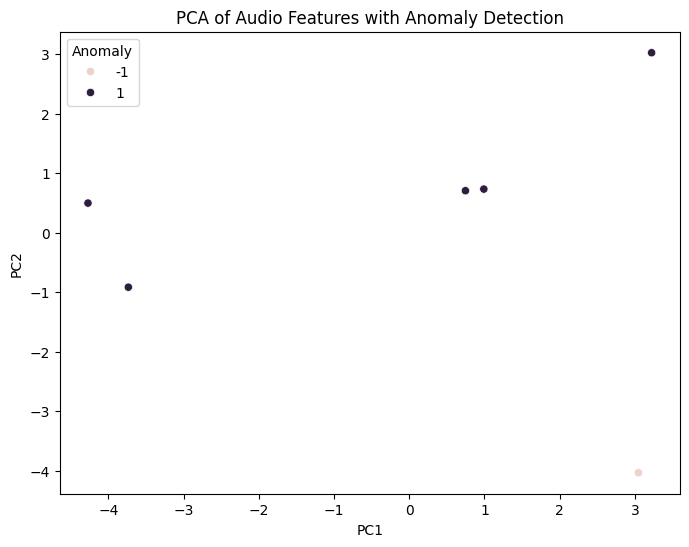

In [53]:
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

plt.figure(figsize=(8,6))
sns.scatterplot(x=X_pca[:,0], y=X_pca[:,1], hue=feature_df['anomaly_score'])
plt.title("PCA of Audio Features with Anomaly Detection")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.legend(title='Anomaly')
plt.show()

## API Function

In [54]:
def detect_cognitive_decline(audio_file_path):
    feats = extract_audio_features(audio_file_path)
    feats_df = pd.DataFrame([feats])
    X_test = StandardScaler().fit(X).transform(feats_df)
    return model_anomaly.predict(X_test)[0]  # -1 is anomaly

In [55]:
# Example for sample file 1
score = detect_cognitive_decline("/content/voice_data/common_voice_en_40865214.mp3")
print("Risk Score:", score)

/usr/local/lib/python3.11/dist-packages/whisper/transcribe.py:132: UserWarning: FP16 is not supported on CPU; using FP32 instead
  warnings.warn("FP16 is not supported on CPU; using FP32 instead")


Risk Score: 1


## Saving Features

In [56]:
feature_df.to_csv("voice_features.csv", index=False)